# Imports and setting up device variable

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
print(f"On device : {device}")

On device : cuda


# Loading data, creating DataLoaders

In [14]:
bs = 32
num_workers = os.cpu_count()

train_transform = T.Compose([
    T.Resize((227, 227)), # original alexnet was implemented in imagenet and was state-of-the-art at the time
    T.RandomRotation(degrees=15), # little bit of data augmentation
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
])

test_transform = T.Compose([T.Resize((227, 227)), T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=num_workers)

In [15]:
img, lbl = next(iter(trainloader))

In [16]:
img.shape, lbl.shape

(torch.Size([32, 1, 227, 227]), torch.Size([32]))

In [17]:
img, lbl = next(iter(testloader))

In [18]:
img.shape, lbl.shape

(torch.Size([32, 1, 227, 227]), torch.Size([32]))

# AlexNet architecture for MNIST

In [25]:
class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.feats_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.LocalResponseNorm(size=2, alpha=0.00002, beta=0.75, k=1),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.LocalResponseNorm(size=2, alpha=0.00002, beta=0.75, k=1),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

    self.classifier = nn.Sequential(
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(4096, 10)
    )


  def forward(self, x):
    x = self.feats_layer(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

# Model Training

In [26]:
model = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [27]:
total_step = len(trainloader)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0.0

    for i, (imgs, lbls) in enumerate(trainloader):
        imgs, lbls = imgs.to(device), lbls.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        train_loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    train_loss_avg = train_loss_sum / len(trainloader)

    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.inference_mode():
        for val_imgs, val_lbls in testloader:
            val_imgs, val_lbls = val_imgs.to(device), val_lbls.to(device)
            val_outputs = model(val_imgs)
            val_loss = criterion(val_outputs, val_lbls)
            total_val_loss += val_loss.item()

            _, predicted = val_outputs.max(1)
            total += val_lbls.size(0)
            correct += predicted.eq(val_lbls).sum().item()

    val_accuracy = 100 * correct / total
    avg_val_loss = total_val_loss / len(testloader)

    print('Validation - Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, avg_val_loss, val_accuracy))

    print('Epoch [{}/{}], Average Train Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss_avg))

Epoch [1/10], Step [400/1875], Train Loss: 0.2606
Epoch [1/10], Step [800/1875], Train Loss: 0.3000
Epoch [1/10], Step [1200/1875], Train Loss: 0.1181
Epoch [1/10], Step [1600/1875], Train Loss: 0.0571
Validation - Epoch [1/10], Test Loss: 0.0464, Test Accuracy: 98.70%
Epoch [1/10], Average Train Loss: 0.3013
Epoch [2/10], Step [400/1875], Train Loss: 0.0096
Epoch [2/10], Step [800/1875], Train Loss: 0.0321
Epoch [2/10], Step [1200/1875], Train Loss: 0.1328
Epoch [2/10], Step [1600/1875], Train Loss: 0.0229
Validation - Epoch [2/10], Test Loss: 0.0252, Test Accuracy: 99.21%
Epoch [2/10], Average Train Loss: 0.0573
Epoch [3/10], Step [400/1875], Train Loss: 0.1918
Epoch [3/10], Step [800/1875], Train Loss: 0.1215
Epoch [3/10], Step [1200/1875], Train Loss: 0.0076
Epoch [3/10], Step [1600/1875], Train Loss: 0.1552
Validation - Epoch [3/10], Test Loss: 0.0183, Test Accuracy: 99.42%
Epoch [3/10], Average Train Loss: 0.0416
Epoch [4/10], Step [400/1875], Train Loss: 0.0014
Epoch [4/10], Ste

# Plotting predictions

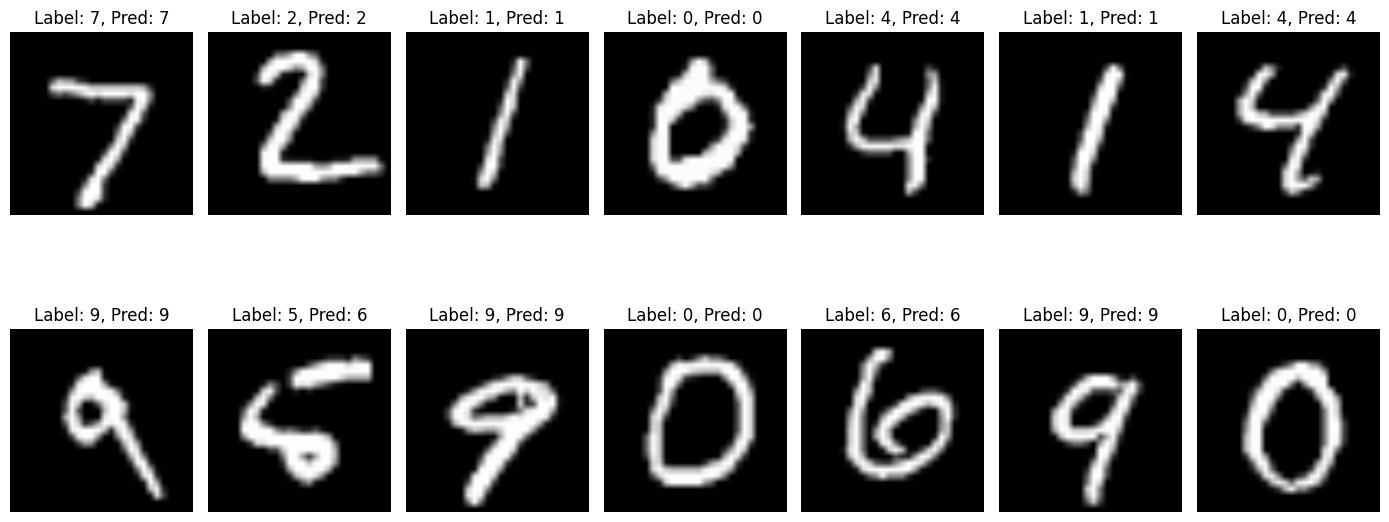

In [28]:
model.eval()

num_images = 14
data_iter = iter(testloader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.inference_mode():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

image_batch = images.cpu().numpy()
label_batch = labels.cpu().numpy()
predicted_batch = predicted.cpu().numpy()

plt.figure(figsize=(14, 7))
for idx in range(num_images):
    plt.subplot(2, 7, idx + 1)
    plt.imshow(np.transpose(image_batch[idx], (1, 2, 0)).squeeze(), cmap='gray')
    plt.title(f'Label: {label_batch[idx]}, Pred: {predicted_batch[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()